In [ ]:
# Extrapolation Notebook - Waste Tax Modeling

'''
This is a shorter Jupyter notebook that will be used to hold my method, and processes for: extrapolating trends, 
normalizing income bins, and setting all datasets to the same base year for fair comparison. Past this point, most inference
will be done manually in a final LaTeX document for submission. 
'''

In [4]:
# Trend Extrapolation - Muni Waste Projections

'''
To extrapolate municipal solid waste beyond 2018, we'll estimate a log-linear trend using historical national MSW data from 1960–2018,
which implies a stable annual growth rate consistent with population and activity scaling. Despite its marginally smaller R^2 value,
relative to a linear model this exponential specification is used as the baseline projection through 2023. Linear trend extrapolation 
will be used as a robustness check, but the exponential model is preferred due to its economic interpretation and assumed stability over
longer horizons. The projection is used solely to construct an aggregate baseline and does not embed distributional or behavioral assumptions.
'''

import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# ---- paths ----
in_path = os.path.expanduser("~/Desktop/DESCO Case/Municipal Waste/Total_MSW_1960_2018.csv")
out_path = os.path.expanduser("~/Desktop/DESCO Case/Municipal Waste/Total_MSW_1960_2023_Projections.csv")

# ---- load ----
df = pd.read_csv(in_path).sort_values("year").reset_index(drop=True)

# keep numeric years/values only
df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["total_msw_generated"] = pd.to_numeric(df["total_msw_generated"], errors="coerce")
df = df.dropna(subset=["year", "total_msw_generated"]).copy()
df["year"] = df["year"].astype(int)

# ---- fit models on 1960–2018 (observed) ----
X = df["year"].values.reshape(-1, 1)
y = df["total_msw_generated"].values

# Linear
lin = LinearRegression().fit(X, y)
y_hat_lin = lin.predict(X)
r2_lin = r2_score(y, y_hat_lin)
rmse_lin = np.sqrt(mean_squared_error(y, y_hat_lin))

# Exponential 
# Guard: waste should be positive for log
if (y <= 0).any():
    raise ValueError("Found non-positive waste values; cannot take log for exponential fit.")
y_log = np.log(y)
exp = LinearRegression().fit(X, y_log)
y_log_hat = exp.predict(X)
r2_exp_log = r2_score(y_log, y_log_hat)
rmse_exp_log = np.sqrt(mean_squared_error(y_log, y_log_hat))

a = exp.intercept_
g = exp.coef_[0]                         
disc_g = np.exp(g) - 1               

# ---- build projection years ----
last_year = int(df["year"].max())
proj_years = np.arange(last_year + 1, 2024)  
X_proj = proj_years.reshape(-1, 1)

# Predictions for observed & projected years
all_years = np.concatenate([df["year"].values, proj_years])
X_all = all_years.reshape(-1, 1)

# Linear predictions
pred_lin_all = lin.predict(X_all)

# Exponential predictions
pred_exp_all = np.exp(a + g * all_years)

# -------------------------------------- CLAUDE.AI PAST THIS POINT -------------------------------------------

# ---- assemble output frame ----
out = pd.DataFrame({
    "year": all_years,
    "msw_observed": np.concatenate([df["total_msw_generated"].values, np.array([np.nan] * len(proj_years))]),
    "msw_linear": pred_lin_all,
    "msw_exponential": pred_exp_all,
})

# Differences (exp - linear)
out["diff_exp_minus_linear"] = out["msw_exponential"] - out["msw_linear"]
out["pct_diff_exp_vs_linear"] = out["diff_exp_minus_linear"] / out["msw_linear"]

# Mark which rows are projections
out["is_projection"] = out["msw_observed"].isna()

# Save
out.to_csv(out_path, index=False)

# Print robustness stats + key comparison 
print("Exponential (log-linear) fit: log(W) = a + g*year")
print(f"  Continuous growth rate g: {g:.6f}  (~{g*100:.4f}% per year)")
print(f"  Discrete growth rate (e^g-1): {disc_g*100:.4f}% per year")
print(f"  R^2 (log scale): {r2_exp_log:.4f}")
print(f"  RMSE (log scale): {rmse_exp_log:.4f}\n")
print("Linear (levels) fit: W = c + b*year")
print(f"  Slope b (units/year): {lin.coef_[0]:.6f}")
print(f"  R^2 (levels): {r2_lin:.4f}")
print(f"  RMSE (levels): {rmse_lin:.4f}\n")

# Compare projected 2023 values specifically
row_2023 = out[out["year"] == 2023].iloc[0]
print("Projection comparison for 2023:")
print(f"  Linear projection (2023):       {row_2023['msw_linear']:.3f}")
print(f"  Exponential projection (2023):  {row_2023['msw_exponential']:.3f}")
print(f"  Difference (exp - lin):         {row_2023['diff_exp_minus_linear']:.3f}")
print(f"  Percent diff vs linear:         {row_2023['pct_diff_exp_vs_linear']*100:.2f}%")
print(f"Saved projections!")

Exponential (log-linear) fit: log(W) = a + g*year
  Continuous growth rate g: 0.018060  (~1.8060% per year)
  Discrete growth rate (e^g-1): 1.8224% per year
  R^2 (log scale): 0.9414
  RMSE (log scale): 0.0805

Linear (levels) fit: W = c + b*year
  Slope b (units/year): 3178690.194221
  R^2 (levels): 0.9661
  RMSE (levels): 10627173.6109

Projection comparison for 2023:
  Linear projection (2023):       294959914.732
  Exponential projection (2023):  318420402.138
  Difference (exp - lin):         23460487.405
  Percent diff vs linear:         7.95%
Saved projections!


In [6]:
# Income Bin Normalization - Doc-String/Methodology created by me ~ All code is CLAUDE.AI 

"""
Distributional bin normalization + merge (ACS income distribution ↔ BLS expenditure bins)

Methodology
--------------------------------------------------
We have two datasets with different income-bin definitions:

1) ACS-style income distribution (household counts + percents) in wider bins:
   e.g., (<$10k, $10–14.9k, $15–24.9k, $25–34.9k, $35–49.9k, $50–74.9k, ...)

2) BLS/CEX-style average annual expenditures in (generally) narrower / shifted bins:
   e.g., (<$15k, $15–29.9k, $30–39.9k, $40–49.9k, $50–69.9k, $70–99.9k, ...)

To place both datasets on a common indexing, we'll re-bin ACS quantities onto the
expenditure bin grid using an overlapping rule:

- Each original ACS bin is treated as an income interval [L, U).
- Each target bin is treated as an income interval [l, u).
- For any target bin, we allocate a fraction of the source bin’s mass proportional
  to the overlap length between intervals:
      weight = overlap([L,U), [l,u)) / length([L,U))
  This essentially equivalent to assuming a uniform distribution of households within each
  source income bracket. This approach also should reduce some of the error associated with our
  exponential growth assumptions as it should pull values closer to a true mean. 

  All code is Claude AI unless otherwise noted in a comment
"""

import re
import numpy as np
import pandas as pd

# -----------------------------
# INPUTS
# -----------------------------
acs_path = "~/Desktop/DESCO Case/Income Data/Cleaned_Year_Wide.csv" # Edited Paths
cex_path = "~/Desktop/DESCO Case/Expenditure by Income/Expenditure_By_Income_2018_2023.csv"

out_path = "~/Desktop/DESCO Case/Income_Expenditure_NormalizedBins_2018_2023.csv"

acs = pd.read_csv(acs_path)
cex = pd.read_csv(cex_path)

acs_label_col = acs.columns[0]          # "Label (Grouping)"
cex_label_col = cex.columns[0]          # "income_bin"

# Keep only the ACS rows that are true income bins (drop totals/mean/median)
drop_labels = {
    "Total households",
    "Mean household income (dollars)",
    "Median household income (dollars)"
}
acs_bins = acs[~acs[acs_label_col].isin(drop_labels)].copy()

# Standardize the “$200,000 or more” vs “$200,000 and more” label
def normalize_bin_label(s: str) -> str:
    s = str(s).replace("\u00a0", " ").strip()
    s = s.replace("or more", "and more")
    return s

acs_bins[acs_label_col] = acs_bins[acs_label_col].map(normalize_bin_label)
cex[cex_label_col] = cex[cex_label_col].map(normalize_bin_label)

# Target bins will be the expenditure bins (rows of CEX file)
target_bins = cex[cex_label_col].tolist()


# PARSE BIN STRINGS -> INTERVALS
def parse_income_bin_to_interval(label: str):
    """
    Convert labels like:
      "Less than $15,000"      -> (0, 15000)
      "$15,000 to $29,999"     -> (15000, 30000)  [treat as half-open; +1 on upper not needed if we use overlap lengths]
      "$200,000 and more"      -> (200000, np.inf)
    Returns: (low, high) with high possibly np.inf
    """
    s = normalize_bin_label(label)

    # Less than
    m = re.match(r"Less than\s*\$(\d[\d,]*)", s, flags=re.IGNORECASE)
    if m:
        hi = int(m.group(1).replace(",", ""))
        return (0.0, float(hi))

    # Range
    m = re.match(r"\$(\d[\d,]*)\s*to\s*\$(\d[\d,]*)", s, flags=re.IGNORECASE)
    if m:
        lo = int(m.group(1).replace(",", ""))
        hi = int(m.group(2).replace(",", ""))
        # Treat "$15,000 to $29,999" as [15000, 30000) for clean overlap math
        return (float(lo), float(hi + 1))

    # Top-coded
    m = re.match(r"\$(\d[\d,]*)\s*(and more|or more)", s, flags=re.IGNORECASE)
    if m:
        lo = int(m.group(1).replace(",", ""))
        return (float(lo), float("inf"))

    raise ValueError(f"Could not parse income bin label: {label}")

def interval_overlap(a, b):
    """Overlap length of intervals a=[L,U), b=[l,u)."""
    L, U = a
    l, u = b
    left = max(L, l)
    right = min(U, u)
    if right <= left:
        return 0.0
    # If either bound is inf, overlap is handled by min/max above.
    if np.isinf(right) and np.isinf(left):
        return 0.0
    if np.isinf(right):
        # overlap from left to infinity: treat as infinite, but this only occurs for top bin mapping
        return float("inf")
    return float(right - left)

# Build target bin intervals
target_intervals = {tb: parse_income_bin_to_interval(tb) for tb in target_bins}

# Build source (ACS) bin intervals
source_bins = acs_bins[acs_label_col].tolist()
source_intervals = {sb: parse_income_bin_to_interval(sb) for sb in source_bins}

# CLEAN ACS NUMERIC COLUMNS
def to_numeric_series(x: pd.Series):
    """Convert strings like '5,507,051' or '4.6%' or '±15,243' -> float (NaN if not parseable)."""
    s = x.astype(str).str.replace("\u00a0", " ", regex=False).str.strip()
    # strip ± and commas
    s = s.str.replace("±", "", regex=False).str.replace(",", "", regex=False)
    # percent -> numeric percent value
    is_pct = s.str.contains("%", na=False)
    s = s.str.replace("%", "", regex=False)
    out = pd.to_numeric(s, errors="coerce")
    # keep percent as percent (not fraction), e.g., 4.6 means 4.6%
    return out

# Identify yearly ACS columns for Estimate and Percent
# Example: "2018_United_States_Estimate", "2018_United_States_Percent"
acs_cols = acs_bins.columns.tolist()
yearly_est_cols = [c for c in acs_cols if re.search(r"\b\d{4}.*Estimate\b", c)]
yearly_pct_cols = [c for c in acs_cols if re.search(r"\b\d{4}.*Percent\b", c) and "Margin" not in c]

# Convert them to numeric
for c in yearly_est_cols + yearly_pct_cols:
    acs_bins[c] = to_numeric_series(acs_bins[c])

# REBIN ACS -> TARGET BINS (by year, for Estimate + Percent)
def rebin_vector(source_values_by_bin: dict, value_type: str):
    """
    Re-bin a dict of {source_bin: value} onto target bins using overlap weights.
    value_type:
      - "mass": allocate additively (counts, totals)
      - "share": allocate additively as well because ACS percent bins represent mass shares;
                if the original shares sum to ~100, rebinned shares should also ~100.
    Returns dict {target_bin: rebinned_value}
    """
    out = {tb: 0.0 for tb in target_bins}

    for sb, v in source_values_by_bin.items():
        if v is None or (isinstance(v, float) and np.isnan(v)):
            continue

        (L, U) = source_intervals[sb]

        # Top-coded: assign entirely to the top target bin that overlaps
        if np.isinf(U):
            for tb in target_bins:
                l, u = target_intervals[tb]
                if np.isinf(u) and l == L:
                    out[tb] += float(v)
                    break
            continue

        length = U - L
        if length <= 0:
            continue

        for tb in target_bins:
            ov = interval_overlap((L, U), target_intervals[tb])
            if ov <= 0:
                continue
            w = ov / length
            out[tb] += float(v) * w

    return out

# Build a normalized frame indexed by target bins
norm = pd.DataFrame({ "income_bin_normalized": target_bins })

# For each year column, re-bin estimates and percents separately
for c in yearly_est_cols:
    year = re.search(r"(\d{4})", c).group(1)
    src = dict(zip(acs_bins[acs_label_col], acs_bins[c]))
    reb = rebin_vector(src, value_type="mass")
    norm[f"{year}_households_estimate"] = norm["income_bin_normalized"].map(reb)

for c in yearly_pct_cols:
    year = re.search(r"(\d{4})", c).group(1)
    src = dict(zip(acs_bins[acs_label_col], acs_bins[c]))
    reb = rebin_vector(src, value_type="share")
    norm[f"{year}_households_percent"] = norm["income_bin_normalized"].map(reb)

# MERGE IN EXPENDITURE (already on target bins)
# Ensure CEX is keyed on the same normalized label
cex2 = cex.rename(columns={cex_label_col: "income_bin_normalized"}).copy()

# Merge (left keeps target bin ordering)
merged = norm.merge(cex2, on="income_bin_normalized", how="left")

# Optional: sort columns for readability
# Put key first, then ACS households, then expenditure columns
key = ["income_bin_normalized"]
acs_house_cols = sorted([c for c in merged.columns if "households_" in c])
exp_cols = sorted([c for c in merged.columns if c.endswith("_average_expenditure")])
other = [c for c in merged.columns if c not in set(key + acs_house_cols + exp_cols)]

merged = merged[key + acs_house_cols + exp_cols + other]

# LIGHT SANITY CHECKS (printed, not required)
# Shares should be ~100 each year (small deviations from rounding are normal)
for yr in sorted(set(re.search(r"(\d{4})", c).group(1) for c in acs_house_cols)):
    pct_col = f"{yr}_households_percent"
    if pct_col in merged.columns:
        s = merged[pct_col].sum(skipna=True)
        print(f"[CHECK] {yr} percent sum (rebinned): {s:.2f}")

# SAVE
merged.to_csv(out_path, index=False)
print(f"Saved normalized + merged dataset!") # Edited to remove identifier

[CHECK] 2018 percent sum (rebinned): 100.00
[CHECK] 2019 percent sum (rebinned): 99.90
[CHECK] 2020 percent sum (rebinned): 100.00
[CHECK] 2021 percent sum (rebinned): 100.00
[CHECK] 2022 percent sum (rebinned): 100.00
[CHECK] 2023 percent sum (rebinned): 100.00
Saved normalized + merged dataset!


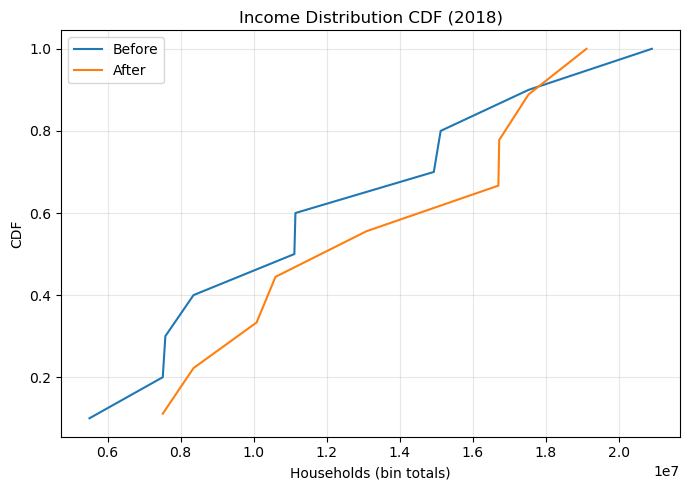

In [ ]:
# CDF's - Checking Redistributions - All code by Me + Cursor
# Note we normalized to expenditure so it is distributionally the same

import numpy as np
import matplotlib.pyplot as plt

def pick_col(df, year="2018", must_contain=(), must_not_contain=()):
    for c in df.columns:
        s = str(c)
        if year not in s:
            continue
        if any(mc not in s for mc in must_contain):
            continue
        if any(mnc in s for mnc in must_not_contain):
            continue
        return c
    raise KeyError("Matching column not found")

def cdf(v):
    v = np.asarray(v, dtype=float)
    v = v[~np.isnan(v)]
    v = np.sort(v)
    return v, np.arange(1, len(v) + 1) / len(v)

year = "2018"

acs_before_col = pick_col(
    acs_bins, year,
    must_contain=("Estimate",),
    must_not_contain=("Margin", "Percent")
)

acs_after_col = pick_col(
    merged, year,
    must_contain=("households_estimate",)
)

# Income Comparison
x1, y1 = cdf(acs_bins[acs_before_col])
x2, y2 = cdf(merged[acs_after_col])

plt.figure(figsize=(7,5))
plt.plot(x1, y1, label="Before")
plt.plot(x2, y2, label="After")
plt.xlabel("Households (bin totals)")
plt.ylabel("CDF")
plt.title("Income Distribution CDF (2018)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()